# Model Notebook
Feature Engineering:
 - Datetime extraction
 - Introduce Phases
 - Use predicted average daily temperature to help fit model.

I have decided to implement 3 different models. The model that returns the best rmse gets to predict future.
1. SARIMAX
2. FBProphet
3. LightGBM

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import holidays

# For SARIMAX
from tqdm import tqdm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# For FBProphet
from fbprophet import Prophet

# For LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import optuna

### Data Preprocessing
The original dataset can be found from data.ny.gov and time ranges from 2010-2020. <br>
https://data.ny.gov/Transportation/Hourly-Traffic-on-Metropolitan-Transportation-Auth/qzve-kjga <br>
The counts are in hourly form and need to be resampled to Daily.
In addition, the bridges('plaza_id') are coded numerically and need to be renamed. <br>
Please note: I have combined Triboro Manhattan and Triboro Bronx into Triboro.

On 2017, NYC finished installing cashless tolls. I will, therefore, use data from 2018 and on because data was collected differently prior to 2017.

In [4]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
    _df['crossing'] = _df['plaza_id'] + '_' + _df['variable']
    
    _df.set_index('datetime', inplace=True)
    _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
    _df = _df.unstack().T
    

    
    return _df


In [5]:
df = return_series('mta.csv')


### 9 Toll Bridges in NYC

There are some days when there were 0 crossings over bridges. (missing values). <br> For this project, I have decided to fill the missing values with the previous day count. <br>





In [8]:

_df = df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [9]:
_df

crossing,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,Throgs Neck_cash,Throgs Neck_ezpass,Triboro_cash,Triboro_ezpass,Verrazano_cash,Verrazano_ezpass,Whitestone_cash,Whitestone_ezpass
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,3527,25636,1876,11829,5523,41017,1096,11022,7338,47569,16177,82169,22395,118380,11583,70340,18818,90468
2018-01-02,4099,43061,2336,19539,5983,54627,1517,18370,6554,60446,12971,93293,20751,144179,9319,86330,14843,102368
2018-01-03,4326,49679,2593,22014,6113,61870,1635,20432,7071,64654,13045,102907,21182,153968,9110,94396,15263,108711
2018-01-04,1552,18932,1092,7211,1519,12983,571,5596,2687,23938,3518,24888,7787,56350,3319,34501,4855,33259
2018-01-05,3103,34904,1900,14939,4700,45150,1102,12827,5465,49688,9585,70892,16429,118824,6841,67534,11586,79643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,7093,48860,3385,18802,7695,52157,2518,18667,10831,52764,14178,83961,26219,130693,11193,86130,20675,101180
2020-10-07,7090,48514,3227,18876,8126,53803,2476,17918,11425,56360,14752,86849,26443,134036,11166,86913,20208,99960
2020-10-08,7313,49405,3313,19392,8370,55294,2559,18748,11800,58204,15760,90958,28160,140175,11907,88834,21469,104514


### Feature Engineering: Holidays
Holidays will be an important feature in determining daily toll traffic. I created a list of all the holidays from 2018-2021.

In [30]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020, 2021]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
bridges = ['Brooklyn Battery_cash', 'Brooklyn Battery_ezpass', 
           'Cross Bay_cash', 'Cross Bay_ezpass', 
           'Henry Hudson_cash', 'Henry Hudson_ezpass',
           'Marine Parkway_cash', 'Marine Parkway_ezpass',
           'Queens Midtown_cash', 'Queens Midtown_ezpass',
           'Throgs Neck_cash', 'Throgs Neck_ezpass', 
           'Triboro_cash', 'Triboro_ezpass', 
           'Verrazano_cash', 'Verrazano_ezpass', 
           'Whitestone_cash', 'Whitestone_ezpass']

In [27]:
_df.columns

Index(['Brooklyn Battery_cash', 'Brooklyn Battery_ezpass', 'Cross Bay_cash',
       'Cross Bay_ezpass', 'Henry Hudson_cash', 'Henry Hudson_ezpass',
       'Marine Parkway_cash', 'Marine Parkway_ezpass', 'Queens Midtown_cash',
       'Queens Midtown_ezpass', 'Throgs Neck_cash', 'Throgs Neck_ezpass',
       'Triboro_cash', 'Triboro_ezpass', 'Verrazano_cash', 'Verrazano_ezpass',
       'Whitestone_cash', 'Whitestone_ezpass', 'month', 'dayofweek', 'year',
       'week', 'day', 'quarter', 'dayofyear', 'Phase', 'weekend', 'holiday',
       'temp_average'],
      dtype='object', name='crossing')

### Feature Engineering: Date Features
From datetime, I extract the month, day of the week, year, weekend... etc. <br> In addition, I have included the 8 events that occurred in **2020**
0. March 12 - Events with more than 500 people cancelled
1. March 22 - NYS Pause Program begins, all non-essential workers must stay home
2. April 16 - Governor Cuomo extendes the stay-at-home order and school closures to May 15
3. May 15 - Governor Cuomo extends PAUSE to May 28
4. June 8 - NYC begins Phase 1 opening
5. June 22 - NYC begins Phase 2 opening
6. July 7 - NYC begins Phase 3 opening
7. July 19 - NYC begins Phase 4 opening

The timeline was extracted from investopedia. <br>
https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986

In [905]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter
    _df['dayofyear'] = _df.index.dayofyear


    conditions = [
        (_df.index >= '2020-03-12') & (_df.index < '2020-03-22'),
        (_df.index >= '2020-03-22') & (_df.index < '2020-04-16'),
        (_df.index >= '2020-04-16') & (_df.index < '2020-05-15'),
        (_df.index >= '2020-05-15') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [12]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(1014, 28)


crossing,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,...,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3527,25636,1876,11829,5523,41017,1096,11022,7338,47569,...,1,0,2018,1,1,1,1,-1,0,1
2018-01-02,4099,43061,2336,19539,5983,54627,1517,18370,6554,60446,...,1,1,2018,1,2,1,2,-1,0,0
2018-01-03,4326,49679,2593,22014,6113,61870,1635,20432,7071,64654,...,1,2,2018,1,3,1,3,-1,0,0
2018-01-04,1552,18932,1092,7211,1519,12983,571,5596,2687,23938,...,1,3,2018,1,4,1,4,-1,0,0
2018-01-05,3103,34904,1900,14939,4700,45150,1102,12827,5465,49688,...,1,4,2018,1,5,1,5,-1,0,0


### Feature Engineer: Average Daily Temperatures
I will predict the average daily temperature from 2018 to current and use the y_hat values as a feature. The temperature data will train from 2010 to 2018.

The dataset comes from https://w2.weather.gov/climate/xmacis.php?wfo=okx with JFK, NY selected.
It ranges from 2010-2020. I will be only taking temp_average of each day.
The dataset will be made applicable via kaggle.


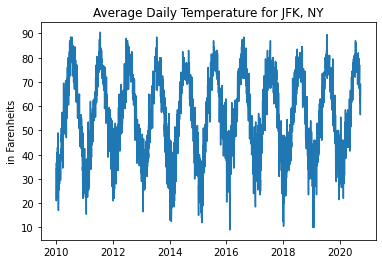

In [13]:
temperature = pd.read_csv('weather.csv', sep ='\t', engine ='python')
temperature['datetime'] = pd.to_datetime(temperature['datetime'])
plt.plot(temperature['datetime'], temperature['temp_average'])
plt.title('Average Daily Temperature for JFK, NY');
plt.ylabel('in Farenheits');

I'll do a quick forecasting on average daily temperature using FBProphet. <br>
Training set was 2010-2017, Testing set: 2018-2020

In [14]:
_temperature = date_features(temperature.set_index('datetime')[['temp_average']])
_fb_weather = _temperature.reset_index()[['datetime', 'temp_average']]
_fb_weather.columns = ['ds', 'y']
_fb_weather.head()

,ds,y
0,2010-01-01,36.5
1,2010-01-02,25.0
2,2010-01-03,21.0
3,2010-01-04,26.0
4,2010-01-05,26.5


In [15]:
m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
m.fit(_fb_weather)

In [16]:
future = m.make_future_dataframe(periods = 365*2)
forecast = m.predict(future)

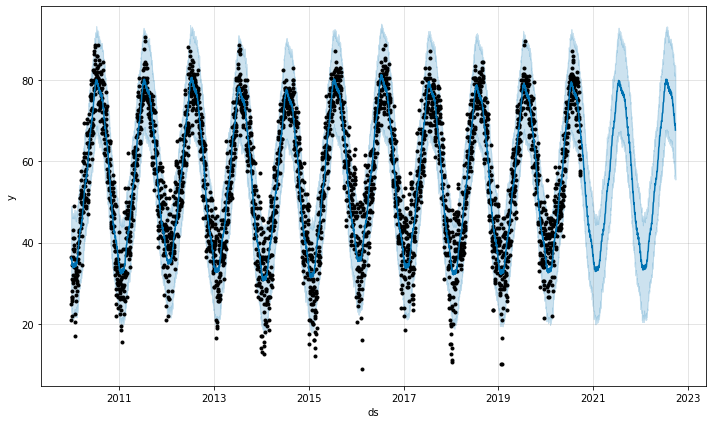

In [17]:
fig1 = m.plot(forecast)

In [22]:
sliced_forecast = forecast.loc[forecast['ds'].isin(pd.date_range(start='2018-01-01', end='2020-10-10'))]
sliced_forecast.reset_index(drop=True, inplace=True)

In [23]:
sliced_forecast = sliced_forecast[['ds', 'yhat']]
sliced_forecast.columns = ['datetime', 'temp_average']
sliced_forecast.set_index('datetime', inplace=True)
sliced_forecast.head()

,temp_average
datetime,
2018-01-01,34.744700
2018-01-02,35.134029
2018-01-03,34.775099
2018-01-04,34.159110
2018-01-05,33.598794


In [24]:
_df['temp_average'] = sliced_forecast['temp_average']

In [25]:
_df

crossing,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,...,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,3527,25636,1876,11829,5523,41017,1096,11022,7338,47569,...,0,2018,1,1,1,1,-1,0,1,34.744700
2018-01-02,4099,43061,2336,19539,5983,54627,1517,18370,6554,60446,...,1,2018,1,2,1,2,-1,0,0,35.134029
2018-01-03,4326,49679,2593,22014,6113,61870,1635,20432,7071,64654,...,2,2018,1,3,1,3,-1,0,0,34.775099
2018-01-04,1552,18932,1092,7211,1519,12983,571,5596,2687,23938,...,3,2018,1,4,1,4,-1,0,0,34.159110
2018-01-05,3103,34904,1900,14939,4700,45150,1102,12827,5465,49688,...,4,2018,1,5,1,5,-1,0,0,33.598794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-06,7093,48860,3385,18802,7695,52157,2518,18667,10831,52764,...,1,2020,41,6,4,280,7,0,0,64.022413
2020-10-07,7090,48514,3227,18876,8126,53803,2476,17918,11425,56360,...,2,2020,41,7,4,281,7,0,0,63.618630
2020-10-08,7313,49405,3313,19392,8370,55294,2559,18748,11800,58204,...,3,2020,41,8,4,282,7,0,0,62.928621


## Models

### Dummy Regressor
My baseline will be the average of the last 7 days for each bridge.
The sum of the 9 rmse (for each bridge) will be my metric.
I have chosen to use root mean squared error because it is more sensitive to larger errors than MAE(mean absolute error) or MAPE(mean absolute percentage error)

In [85]:
bridges

['Brooklyn Battery_cash',
 'Brooklyn Battery_ezpass',
 'Cross Bay_cash',
 'Cross Bay_ezpass',
 'Henry Hudson_cash',
 'Henry Hudson_ezpass',
 'Marine Parkway_cash',
 'Marine Parkway_ezpass',
 'Queens Midtown_cash',
 'Queens Midtown_ezpass',
 'Throgs Neck_cash',
 'Throgs Neck_ezpass',
 'Triboro_cash',
 'Triboro_ezpass',
 'Verrazano_cash',
 'Verrazano_ezpass',
 'Whitestone_cash',
 'Whitestone_ezpass']

In [86]:
crossing_rates = {'Brooklyn Battery_cash':9.50,
                 'Brooklyn Battery_ezpass':6.12,
                 'Cross Bay_cash':4.75,
                 'Cross Bay_ezpass':2.29,
                 'Henry Hudson_cash':7.00,
                 'Henry Hudson_ezpass':2.80,
                 'Marine Parkway_cash':4.75,
                 'Marine Parkway_ezpass':2.29,
                 'Queens Midtown_cash':9.50,
                 'Queens Midtown_ezpass':6.12,
                 'Throgs Neck_cash': 9.50,
                 'Throgs Neck_ezpass': 6.12,
                 'Triboro_cash': 9.50,
                 'Triboro_ezpass':6.12,
                 'Verrazano_cash':19.00,
                 'Verrazano_ezpass':12.24,
                 'Whitestone_cash':9.50,
                 'Whitestone_ezpass':6.12}

In [99]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'
_total_dollars = 0
for crossing,rate in crossing_rates.items():
    _total_dollars += _df[te_start:te_end][crossing].sum() * rate

    
_total_dollars

173780402.32

In [100]:
tr_start,tr_end = '2018-01-01','2020-09-05'
te_start,te_end = '2020-09-06','2020-10-10'


dummy_MA7 = []
_dummy_dollars = 0
for crossing,rate in crossing_rates.items():
    tes = _df[te_start:te_end][crossing]
    tra = _df[tr_start:tr_end][crossing]
    _dummy = pd.DataFrame()
    _dummy['datetime'] = pd.date_range(start='2020-09-06', end='2020-10-10')
    _dummy.set_index('datetime', inplace=True)
    _dummy[crossing] = tra.tail(7).mean()
    
    _dummy_dollars += _dummy[crossing].sum() * rate

    

In [102]:
_dummy_dollars - _total_dollars

5076338.430000007

In [36]:
_results_df = pd.DataFrame()
_results_df['bridges'] = bridges
_results_df['dummy_MA7'] = dummy_MA7
_results_df

,bridges,dummy_MA7
0,Brooklyn Battery_cash,897.963817
1,Brooklyn Battery_ezpass,8555.505708
2,Cross Bay_cash,799.763228
3,Cross Bay_ezpass,2891.665227
4,Henry Hudson_cash,1033.794866
5,Henry Hudson_ezpass,6001.858192
6,Marine Parkway_cash,1211.033429
7,Marine Parkway_ezpass,4535.955593
8,Queens Midtown_cash,1186.325490
9,Queens Midtown_ezpass,8093.426751


In [37]:
_results_df.sum(axis=0)

bridges      Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                              74391.5
dtype: object

### SARIMAX
I will use the features created from above as my independent exogenous variables. <br>
the values (p,d,q)x(P,D,Q,m), and trend was found through grid searching. <br>

I have used m=7 because the data points are daily.

### One Hot Encoder
After all features have been created, I will need to dummify the categorical features for SARIMAX.

In [34]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df['temp_average'] = _df['temp_average']
_df_ohe_df.shape

(1014, 31)

In [120]:
def return_sarimax_rmse(bridge, rate, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-09-05'
    te_start,te_end = '2020-09-06','2020-10-10'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    _dollars = pred.sum() * rate
    
    return _dollars

### Grid Search
I took this technique from machine learning mastery. It brute forces the combinations. <br>
I have set m = 7 because this is daily data. <br>
The selected params were (1,1,2)x(1,0,1,7) trend='n'


In [37]:
# code was taken from machine learning mastery
models = list()
p_params = [0, 1, 2]
d_params = [0, 1]
q_params = [0, 1, 2]
t_params = ['n','c','t','ct']
P_params = [0, 1, 2]
D_params = [0, 1]
Q_params = [0, 1, 2]
m_params = [7]
# create config instances
for p in p_params:
    for d in d_params:
        for q in q_params:
            for t in t_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                cfg = [(p,d,q), (P,D,Q,m), t]
                                models.append(cfg)


In [38]:
# # This grid search took around 40 hours. Please don't run this.
# _grid_sarimax = []
# for model in tqdm(models):
#     _each_grid = []
#     for i in bridges:
#         _each_grid.append(return_sarimax_rmse(i, model[0], model[1], model[2]))
#     print((sum(l7), model))
#     _grid_sarimax.append((sum(l7), model))

In [121]:
# Please note, I fit a sarimax model for each of the 9 bridges and returned an rmse from the test set.
# I should have 9 rmse (one for each bridge), the summation of the rmse will be the final metric.


    
_sarimax_rmse = []
_sarimax_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _sarimax_dollars += return_sarimax_rmse(crossing, rate, (1,1,2), (1,0,1,7), 'n')

100%|██████████| 18/18 [02:58<00:00,  9.93s/it]


In [122]:
_sarimax_dollars - _total_dollars

-660873.628728658

In [109]:
_sarimax_dollars

133.22

In [41]:
_results_df['SARIMAX'] = _sarimax_rmse
_results_df

,bridges,dummy_MA7,SARIMAX
0,Brooklyn Battery_cash,897.963817,612.227203
1,Brooklyn Battery_ezpass,8555.505708,3230.593207
2,Cross Bay_cash,799.763228,552.047553
3,Cross Bay_ezpass,2891.665227,1760.772889
4,Henry Hudson_cash,1033.794866,615.152942
5,Henry Hudson_ezpass,6001.858192,4011.601010
6,Marine Parkway_cash,1211.033429,980.635087
7,Marine Parkway_ezpass,4535.955593,3085.176388
8,Queens Midtown_cash,1186.325490,1090.033137
9,Queens Midtown_ezpass,8093.426751,5363.611894


In [42]:
_results_df.sum(axis=0)

bridges      Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                              74391.5
SARIMAX                                                45896.3
dtype: object

### FBProphet
After implement SARIMAX, I will now move on to FBProphet. <br>
Please note, the FBProphet was not hyperturned

In [124]:
def return_prophet_rmse(bridge, rate):
    tr_start,tr_end = '2018-01-01','2020-09-05'
    te_start,te_end = '2020-09-06','2020-10-10'
    tra = _df_merged[tr_start:tr_end][[bridge]]
    tes = _df_merged[te_start:te_end][[bridge]]
    _fb_exog = _df_merged[['month', 'dayofweek', 'quarter',
           'Phase', 'weekend', 'holiday', 'temp_average']]

    tra = tra.join(_fb_exog)
    tes = tes.join(_fb_exog)


    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    tra = tra.reset_index()
    tra = tra.rename(columns = {bridge:'y', 'datetime': 'ds'})
    tes = tes.reset_index()
    tes = tes.rename(columns = {bridge:'y', 'datetime': 'ds'})


    m = Prophet(
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 300,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    for i in _fb_exog.columns:
        m.add_regressor(i)


    m.fit(tra)
    
    # Please change the periods after changing the te_start and te_end. For this case i have made periods 35 because there are 35 days on the the test set.
    future = m.make_future_dataframe(periods=35)
    future.set_index('ds', inplace=True)
    future = future.join(_fb_exog)
    future.reset_index(inplace=True)
    pred = m.predict(future[-35:])
    _dollars = pred['yhat'].sum() * rate
    
    return _dollars

In [125]:
fb_prophet_1 = []

_fbprophet_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _fbprophet_dollars += return_prophet_rmse(crossing, rate)


100%|██████████| 18/18 [09:34<00:00, 31.90s/it]


In [126]:
_fbprophet_dollars - _total_dollars

-413098.18853238225

In [668]:
_fbprophet_dollars

173367304.1314676

In [44]:
fb_prophet_1 = []

_fbprophet_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _fbprophet_dollars += return_prophet_rmse(crossing, rate)
for i in tqdm(bridges):
    fb_prophet_1.append(return_prophet_rmse(i))
    
_results_df['FB_prophet_1'] = fb_prophet_1
_results_df

100%|██████████| 18/18 [09:37<00:00, 32.11s/it]


,bridges,dummy_MA7,SARIMAX,FB_prophet_1
0,Brooklyn Battery_cash,897.963817,612.227203,618.120912
1,Brooklyn Battery_ezpass,8555.505708,3230.593207,3355.836134
2,Cross Bay_cash,799.763228,552.047553,416.696658
3,Cross Bay_ezpass,2891.665227,1760.772889,1380.337438
4,Henry Hudson_cash,1033.794866,615.152942,739.011878
5,Henry Hudson_ezpass,6001.858192,4011.601010,2926.605642
6,Marine Parkway_cash,1211.033429,980.635087,587.413843
7,Marine Parkway_ezpass,4535.955593,3085.176388,2518.548791
8,Queens Midtown_cash,1186.325490,1090.033137,1342.400382
9,Queens Midtown_ezpass,8093.426751,5363.611894,5905.471540


In [45]:
_results_df.sum(axis=0)

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
dtype: object

### LightGBM
After using tuned SARIMAX and a more-or-less generic FBProphet, I thought it was a good opportunity to try changing the time series problem into a decision tree regression problem. Instead of having 9 separate models for each bridge, we can have 1 GBDT model. This is done by first melting all the columns and making the dataframe long. As I have created features in the SARIMAX and FBProphet models, I will do the same here.

In [255]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    df = df.loc[~df.duplicated()]
    df = df.loc[df['Date_Hour'] >= '2018'].copy(deep=True)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df.drop(columns=['Plaza ID', 'Direction'], inplace=True)
    df.columns = ['datetime', 'ezpass', 'cash', 'plaza_id']
    _df = df.melt(id_vars=['datetime','plaza_id'], value_vars=['ezpass', 'cash'])
#     _df['crossing'] = _df['plaza_id'] + '_' + _df['variable']
    
#     _df.set_index('datetime', inplace=True)
#     _df = _df.groupby(['crossing'])['value'].resample('1D').sum()
#     _df = _df.unstack().T
    

    
    return _df


In [907]:
lgbm_df = return_series('mta.csv')

In [908]:
lgbm_df.set_index('datetime', inplace=True)

In [909]:
_ffill_lgbm = lgbm_df.groupby(['plaza_id', 'variable'])['value'].resample('1D').sum()

In [910]:
_ffill_lgbm = _ffill_lgbm.reset_index()

In [911]:
_ffill_lgbm = _ffill_lgbm.pivot(index='datetime', columns = ['plaza_id', 'variable'], values='value')

In [912]:
for i in crossing_rates.keys():
    _ffill_lgbm[i] = _ffill_lgbm[i].replace(to_replace=0, method='ffill')

In [913]:
_ffill_lgbm = _ffill_lgbm.unstack().reset_index()

In [914]:
_ffill_lgbm.rename(columns={0: 'value'}, inplace=True)

In [915]:
_ffill_lgbm.set_index('datetime', inplace=True)

In [916]:
_var = {'cash':0, 'ezpass': 1}
_ffill_lgbm['variable'] = [_var[item] for item in _ffill_lgbm['variable']]

In [917]:
_ffill_lgbm.isna().sum()

plaza_id    0
variable    0
value       0
dtype: int64

In [918]:
le = LabelEncoder()
_ffill_lgbm['plaza_id'] = le.fit_transform(_ffill_lgbm['plaza_id'])

In [919]:
_ffill_lgbm

,plaza_id,variable,value
datetime,,,
2018-01-01,0,0,3527
2018-01-02,0,0,4099
2018-01-03,0,0,4326
2018-01-04,0,0,1552
2018-01-05,0,0,3103
...,...,...,...
2020-10-06,8,1,101180
2020-10-07,8,1,99960
2020-10-08,8,1,104514


In [920]:
_ffill_lgbm = date_features(_ffill_lgbm)

_ffill_lgbm = _ffill_lgbm.join(sliced_forecast)
# There are many instances where I'll set an index to datetime and reset it.
# This is my fault for not making the data preprocessing functions take the same columns. For example: date_features takes index, while date_lag takes the column
_ffill_lgbm.reset_index(inplace=True)

In [921]:
_ffill_lgbm.rename(columns={'plaza_id':'crossing'}, inplace=True)

In [922]:
# Creating 3 sliced dataframes
train_set = _ffill_lgbm.loc[_ffill_lgbm['datetime'] <= '2020-09-05'].copy(deep=True)
test_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05') & (_ffill_lgbm['datetime'] <= '2020-10-10')].copy(deep=True)
pred_set = _ffill_lgbm.loc[(_ffill_lgbm['datetime'] > '2020-09-05')].copy(deep=True)
pred_set['value'] = np.nan
pred_set.tail()

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
18247,2020-10-10,6,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18248,2020-10-10,7,0,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18249,2020-10-10,7,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18250,2020-10-10,8,0,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719
18251,2020-10-10,8,1,NaN,10,5,2020,41,10,4,284,7,1,0,61.682719


In [923]:
train_set

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,dayofyear,Phase,weekend,holiday,temp_average
0,2018-01-01,0,0,3527,1,0,2018,1,1,1,1,-1,0,1,34.744700
1,2018-01-01,0,1,25636,1,0,2018,1,1,1,1,-1,0,1,34.744700
2,2018-01-01,1,0,1876,1,0,2018,1,1,1,1,-1,0,1,34.744700
3,2018-01-01,1,1,11829,1,0,2018,1,1,1,1,-1,0,1,34.744700
4,2018-01-01,2,0,5523,1,0,2018,1,1,1,1,-1,0,1,34.744700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17617,2020-09-05,6,1,121053,9,5,2020,36,5,3,249,7,1,0,72.496286
17618,2020-09-05,7,0,14508,9,5,2020,36,5,3,249,7,1,0,72.496286
17619,2020-09-05,7,1,82759,9,5,2020,36,5,3,249,7,1,0,72.496286
17620,2020-09-05,8,0,26880,9,5,2020,36,5,3,249,7,1,0,72.496286


In [924]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    
#     _df['lag_1'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(1)
#     _df['lag_2'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(2)
    
#     _df['mean_lag1_roll7'] = _df[['crossing', 'variable','value', 'lag_1']].groupby(['crossing', 'variable'])['lag_1'].apply(lambda x: x.rolling(7).mean())
#     _df['mean_lag1_roll3'] = _df[['crossing', 'variable','value', 'lag_1']].groupby(['crossing', 'variable'])['lag_1'].apply(lambda x: x.rolling(3).mean())
#     _df['diff_7'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].diff(7)
    
    _df['lag_7'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(7)
#     _df['lag_14'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(14)
#     _df['lag_21'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(21)
    _df['lag_28'] = _df[['crossing', 'variable','value']].groupby(['crossing', 'variable'])['value'].shift(28)
#     _df['lag_35'] = _df[['crossing', 'value']].groupby('crossing')['value'].shift(35)

    
    
    _df['mean_lag7_roll7'] = _df[['crossing', 'variable','value', 'lag_7']].groupby(['crossing', 'variable'])['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['crossing', 'variable','value', 'lag_7']].groupby(['crossing', 'variable'])['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['crossing', 'variable','value', 'lag_28']].groupby(['crossing', 'variable'])['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['crossing', 'variable','value', 'lag_28']].groupby(['crossing', 'variable'])['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [926]:
train_set = date_lags(train_set)
train_set.tail()

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,...,Phase,weekend,holiday,temp_average,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
17617,2020-09-05,6,1,121053,9,5,2020,36,5,3,...,7,1,0,72.496286,100790.0,113866.0,126619.571429,126622.571429,122801.571429,124957.857143
17618,2020-09-05,7,0,14508,9,5,2020,36,5,3,...,7,1,0,72.496286,12372.0,14061.0,12774.142857,12780.142857,12172.571429,12332.964286
17619,2020-09-05,7,1,82759,9,5,2020,36,5,3,...,7,1,0,72.496286,72128.0,79371.0,84448.285714,83557.714286,79144.571429,80685.571429
17620,2020-09-05,8,0,26880,9,5,2020,36,5,3,...,7,1,0,72.496286,21921.0,25060.0,22861.142857,22830.035714,21770.571429,21843.785714
17621,2020-09-05,8,1,105655,9,5,2020,36,5,3,...,7,1,0,72.496286,85478.0,98837.0,102611.000000,101443.571429,95833.285714,96282.857143


In [928]:
categorical_features = ['crossing', 'variable', 'month', 'dayofweek', 'day', 'week', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value', 'year']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [929]:
# train test split
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [930]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


#### Optuna
Optuna looks very similiarly to randomized Search CV. More importantly, it displays a progress bar and results paramter after each iteration. <br> I decided to use this to find the best parameters.

In [931]:
def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 64),
        'num_leaves': trial.suggest_int('num_leaves', 54, 124),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=500, early_stopping_rounds=500)
    
    train_roll = train_set.copy(deep=True)
    try:
        for i in tqdm(range(1,500)):
            _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
            _first_concat = pd.concat([train_roll, _to_pred])
            _first_concat.reset_index(inplace=True, drop=True)
            _first_concat = date_lags(_first_concat)
            _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
            _to_pred_feats = _to_pred[train_cols]
            first_pred = m_lgb.predict(_to_pred_feats)
            _to_pred['value'] = first_pred
            train_roll = pd.concat([train_roll, _to_pred])
    except:
        print('end of loop')
    
    
    _inverse_variable = {0: 'cash', 1: 'ezpass'}
    _lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
    _lgbm_pred['variable'] = [_inverse_variable[item] for item in _lgbm_pred['variable']]
    _lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])
    
    _lgbm_pivot = _lgbm_pred.pivot(index='datetime', columns=['crossing', 'variable'], values='value')
#     test_set['variable'] = [_inverse_variable[item] for item in test_set['variable']]
#     test_set['crossing'] = le.inverse_transform(test_set['crossing'])
    
#     _test_pivot = test_set.pivot(index='datetime', columns = ['crossing', 'variable'], values='value')
    
    _lgbm_dollars = 0
    for i,x in crossing_rates.items():
        _lgbm_dollars += _lgbm_pivot[i].sum() * x
    
    
    return _lgbm_dollars

In [932]:
# 100 trials: this can take a while, feel free to interrupt at any time
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [933]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 38,
    'num_leaves': 83,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.5163386620025411,
    'feature_fraction': 0.8282029364551513,
    'lambda_l1' : 0.32608335857159515,
    'lambda_l2' : 0.47993551029860304,
    'verbosity': 1

}
# params taken from optuna
# {'max_depth': 38, 'num_leaves': 83, 'bag_frac': 0.5163386620025411, 'feat_frac': 0.8282029364551513, 'l1': 0.32608335857159515, 'l2': 0.47993551029860304}

In [934]:
m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 500 rounds
[100]	valid_0's rmse: 6257.31
[200]	valid_0's rmse: 5224.49
[300]	valid_0's rmse: 5217.55
[400]	valid_0's rmse: 5088.98
[500]	valid_0's rmse: 5042.26
[600]	valid_0's rmse: 5011.79
[700]	valid_0's rmse: 4995.72
[800]	valid_0's rmse: 4980.19
[900]	valid_0's rmse: 4975.44
[1000]	valid_0's rmse: 4970.51
[1100]	valid_0's rmse: 4960.67
[1200]	valid_0's rmse: 4948.27
[1300]	valid_0's rmse: 4937.81
[1400]	valid_0's rmse: 4937.52
[1500]	valid_0's rmse: 4935.65
[1600]	valid_0's rmse: 4934.81
[1700]	valid_0's rmse: 4932.26
[1800]	valid_0's rmse: 4929.23
[1900]	valid_0's rmse: 4929.55
[2000]	valid_0's rmse: 4928.72
[2100]	valid_0's rmse: 4928.62
[2200]	valid_0's rmse: 4924.83
[2300]	valid_0's rmse: 4921.93
[2400]	valid_0's rmse: 4919.9
[2500]	valid_0's rmse: 4919.77
[2600]	valid_0's rmse: 4920.51
[2700]	valid_0's rmse: 4919.99
[2800]	valid_0's rmse: 4918.1
[2900]	valid_0's rmse: 4917.99
[3000]	valid_0's rmse: 4916.43
[3100]	valid_0's rm

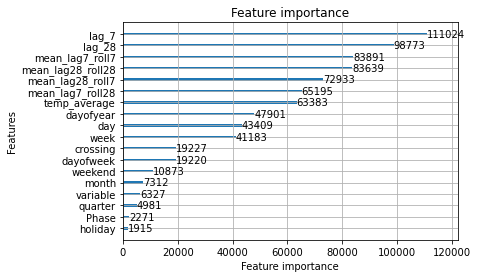

In [936]:
lgb.plot_importance(m_lgb)

In [937]:
train_roll = train_set.copy(deep=True)
try:
    for i in tqdm(range(1,500)):
        _to_pred = pred_set.loc[pred_set['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat.reset_index(inplace=True, drop=True)
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'] == (datetime.datetime(2020, 9, 5) + datetime.timedelta(days= i))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

  7%|▋         | 35/499 [00:04<00:59,  7.80it/s]


end of loop


In [938]:
train_roll

,datetime,crossing,variable,value,month,dayofweek,year,week,day,quarter,...,Phase,weekend,holiday,temp_average,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,0,0,3527.000000,1,0,2018,1,1,1,...,-1,0,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,0,1,25636.000000,1,0,2018,1,1,1,...,-1,0,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,1,0,1876.000000,1,0,2018,1,1,1,...,-1,0,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,1,1,11829.000000,1,0,2018,1,1,1,...,-1,0,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,2,0,5523.000000,1,0,2018,1,1,1,...,-1,0,1,34.744700,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18247,2020-10-10,6,1,136272.200955,10,5,2020,41,10,4,...,7,1,0,61.682719,131629.184496,122540.386108,141584.409894,138165.630840,133525.779586,130013.159182
18248,2020-10-10,7,0,14314.896270,10,5,2020,41,10,4,...,7,1,0,61.682719,14156.256690,14617.495734,12909.572717,12327.484477,12332.109877,12872.527469
18249,2020-10-10,7,1,90538.339744,10,5,2020,41,10,4,...,7,1,0,61.682719,86438.974921,86264.187953,87416.938062,87589.620849,86145.428905,85702.500084
18250,2020-10-10,8,0,23285.501681,10,5,2020,41,10,4,...,7,1,0,61.682719,24230.179790,25507.211581,22133.330763,21581.650190,21715.518731,22864.558254


In [939]:
_lgbm_pred

,datetime,crossing,variable,value
17622,2020-09-06,Brooklyn Battery,cash,7119.906091
17623,2020-09-06,Brooklyn Battery,ezpass,33282.155049
17624,2020-09-06,Cross Bay,cash,4651.989109
17625,2020-09-06,Cross Bay,ezpass,20618.644244
17626,2020-09-06,Henry Hudson,cash,9219.806982
...,...,...,...,...
18247,2020-10-10,Triboro,ezpass,124373.228536
18248,2020-10-10,Verrazano,cash,15732.641910
18249,2020-10-10,Verrazano,ezpass,86408.142021
18250,2020-10-10,Whitestone,cash,24761.688237


In [940]:
_inverse_variable = {0: 'cash', 1: 'ezpass'}
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
_lgbm_pred['variable'] = [_inverse_variable[item] for item in _lgbm_pred['variable']]
_lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])

In [941]:
_lgbm_pred

,datetime,crossing,variable,value
17622,2020-09-06,Brooklyn Battery,cash,6243.490286
17623,2020-09-06,Brooklyn Battery,ezpass,35860.172446
17624,2020-09-06,Cross Bay,cash,3563.089441
17625,2020-09-06,Cross Bay,ezpass,18113.642581
17626,2020-09-06,Henry Hudson,cash,8225.700910
...,...,...,...,...
18247,2020-10-10,Triboro,ezpass,136272.200955
18248,2020-10-10,Verrazano,cash,14314.896270
18249,2020-10-10,Verrazano,ezpass,90538.339744
18250,2020-10-10,Whitestone,cash,23285.501681


In [942]:
_lgbm_pivot = _lgbm_pred.pivot(index='datetime', columns=['crossing', 'variable'], values='value')

In [943]:
_lgbm_pivot.columns

MultiIndex([('Brooklyn Battery',   'cash'),
            ('Brooklyn Battery', 'ezpass'),
            (       'Cross Bay',   'cash'),
            (       'Cross Bay', 'ezpass'),
            (    'Henry Hudson',   'cash'),
            (    'Henry Hudson', 'ezpass'),
            (  'Marine Parkway',   'cash'),
            (  'Marine Parkway', 'ezpass'),
            (  'Queens Midtown',   'cash'),
            (  'Queens Midtown', 'ezpass'),
            (     'Throgs Neck',   'cash'),
            (     'Throgs Neck', 'ezpass'),
            (         'Triboro',   'cash'),
            (         'Triboro', 'ezpass'),
            (       'Verrazano',   'cash'),
            (       'Verrazano', 'ezpass'),
            (      'Whitestone',   'cash'),
            (      'Whitestone', 'ezpass')],
           names=['crossing', 'variable'])

In [944]:
crossing_rates = {('Brooklyn Battery', 'cash'):9.50,
                 ('Brooklyn Battery', 'ezpass'):6.12,
                 ('Cross Bay', 'cash'):4.75,
                 ('Cross Bay', 'ezpass'):2.29,
                 ('Henry Hudson','cash'):7.00,
                 ('Henry Hudson','ezpass'):2.80,
                 ('Marine Parkway','cash'):4.75,
                 ('Marine Parkway','ezpass'):2.29,
                 ('Queens Midtown','cash'):9.50,
                 ('Queens Midtown','ezpass'):6.12,
                 ('Throgs Neck','cash'): 9.50,
                 ('Throgs Neck','ezpass'): 6.12,
                 ('Triboro','cash'): 9.50,
                 ('Triboro','ezpass'):6.12,
                 ('Verrazano','cash'):19.00,
                 ('Verrazano','ezpass'):12.24,
                 ('Whitestone','cash'):9.50,
                 ('Whitestone','ezpass'):6.12}

In [945]:
crossing_rates

{('Brooklyn Battery', 'cash'): 9.5,
 ('Brooklyn Battery', 'ezpass'): 6.12,
 ('Cross Bay', 'cash'): 4.75,
 ('Cross Bay', 'ezpass'): 2.29,
 ('Henry Hudson', 'cash'): 7.0,
 ('Henry Hudson', 'ezpass'): 2.8,
 ('Marine Parkway', 'cash'): 4.75,
 ('Marine Parkway', 'ezpass'): 2.29,
 ('Queens Midtown', 'cash'): 9.5,
 ('Queens Midtown', 'ezpass'): 6.12,
 ('Throgs Neck', 'cash'): 9.5,
 ('Throgs Neck', 'ezpass'): 6.12,
 ('Triboro', 'cash'): 9.5,
 ('Triboro', 'ezpass'): 6.12,
 ('Verrazano', 'cash'): 19.0,
 ('Verrazano', 'ezpass'): 12.24,
 ('Whitestone', 'cash'): 9.5,
 ('Whitestone', 'ezpass'): 6.12}

In [946]:
test_set['variable'] = [_inverse_variable[item] for item in test_set['variable']]

In [947]:
test_set['crossing'] = le.inverse_transform(test_set['crossing'])

In [948]:
_test_pivot = test_set.pivot(index='datetime', columns = ['crossing', 'variable'], values='value')

In [949]:
_test_dollars = 0
for i,x in crossing_rates.items():
    _test_dollars += _test_pivot[i].sum() * x

In [950]:
_test_dollars

173780402.32

In [951]:
_lgbm_dollars = 0
for i,x in crossing_rates.items():
    _lgbm_dollars += _lgbm_pivot[i].sum() * x

In [952]:
_lgbm_dollars

177711402.4292373

In [953]:
_lgbm_dollars - _test_dollars

3931000.1092373133

In [744]:
_test_pivot

crossing   Brooklyn Battery        Cross Bay        Henry Hudson         \
variable               cash ezpass      cash ezpass         cash ezpass   
datetime                                                                  
2020-09-06             6117  30212      5033  21712         7646  39753   
2020-09-07             5096  26185      4479  19265         7338  39943   
2020-09-08             7067  48038      3723  20921         8249  52342   
2020-09-09             7299  49254      3197  19495         7970  54056   
2020-09-10             7001  48671      2972  17770         7947  52680   
2020-09-11             8412  48466      3594  20899         9942  60717   
2020-09-12             6373  33000      3547  18167         9498  49125   
2020-09-13             5622  29947      2974  15320         6984  40328   
2020-09-14             7039  47134      3448  19321         7758  50456   
2020-09-15             7059  48456      3312  19223         8001  54097   
2020-09-16             7144  47924      3201  19159         7893  53611   
2020-09-17             7414  50449      3367  19263         8446  56802   
2020-09-18             7892  48118      3389  19678        10121  60502   
2020-09-19             6688  33910      3244  17017         9485  48963   
2020-09-20             5145  26614      2776  14633         7892  42830   
2020-09-21             6883  45178      2966  18109         8070  50502   
2020-09-22             7137  48129      3328  19380         8084  52792   
2020-09-23             7354  50102      3612  20659         8520  56115   
2020-09-24             7553  49494      3173  19502         9238  58189   
2020-09-25             8190  50476      3599  20703        10649  61564   
2020-09-26             6756  36662      3269  17050         9897  51542   
2020-09-27             5292  28346      2937  15961         8291  43456   
2020-09-28             5762  35586      3005  17535         7211  45275   
2020-09-29             6881  48250      3013  18058         7680  51968   
2020-09-30             7298  49791      3262  18869         8275  54657   
2020-10-01             7871  51671      3405  20417         8800  58247   
2020-10-02             7681  48991      3482  20210        10208  60587   
2020-10-03             7157  35244      3133  16884         9799  50638   
2020-10-04             4910  26317      2573  14302         8245  44802   
2020-10-05             6750  45939      3066  18206         7562  48787   
2020-10-06             7093  48860      3385  18802         7695  52157   
2020-10-07             7090  48514      3227  18876         8126  53803   
2020-10-08             7313  49405      3313  19392         8370  55294   
2020-10-09             7540  46132      3402  19839        10035  60207   
2020-10-10             6316  34818      3177  16757        10105  51852   

crossing   Marine Parkway        Queens Midtown        Throgs Neck         \
variable             cash ezpass           cash ezpass        cash ezpass   
datetime                                                                    
2020-09-06           5524  26312           9804  34976       21163  95740   
2020-09-07           4510  23131           9018  35091       19276  88550   
2020-09-08           3450  22074          11666  54996       16068  90434   
2020-09-09           2877  19944          11353  55885       15121  89586   
2020-09-10           2565  17930          11189  54720       14689  85469   
2020-09-11           3217  21266          13150  60236       17254  93955   
2020-09-12           3249  18416          11830  46223       19070  91079   
2020-09-13           2883  15867           9668  38228       17919  85451   
2020-09-14           3048  19650          11071  52747       14968  85243   
2020-09-15           2978  19763          11623  56283       14776  86100   
2020-09-16           2699  19577          11182  55362       14509  86537   
2020-09-17           2637  20264          12130  59576       15200  900

In [745]:
_lgbm_pivot

crossing   Brooklyn Battery                  Cross Bay                \
variable               cash        ezpass         cash        ezpass   
datetime                                                               
2020-09-06      7435.343798  30327.365494  5383.294444  19636.551262   
2020-09-07      8161.668066  36275.991328  5905.233101  19784.469290   
2020-09-08      8913.883211  46788.189256  6431.998651  22178.962055   
2020-09-09      9186.775457  48546.592607  7160.529851  22688.857895   
2020-09-10      9521.193613  51286.376481  7744.244315  23607.269835   
2020-09-11     10022.895509  51056.453292  8301.185434  23551.631538   
2020-09-12     10107.581967  43232.725644  8348.684405  20344.219417   
2020-09-13     10090.058762  39214.570061  8465.834329  19367.164857   
2020-09-14      9820.123574  47948.931000  8475.547425  20595.711868   
2020-09-15     10089.506458  50335.685179  8378.765058  22362.857377   
2020-09-16     10101.136159  51518.335104  8193.887153  22531.568434   
2020-09-17     10468.873292  52281.722403  8447.189500  23237.792598   
2020-09-18     10542.503039  52675.385038  8614.221923  23657.106245   
2020-09-19     10562.080644  43004.254951  8310.948586  21301.563921   
2020-09-20     10121.300708  40790.632494  8168.644765  20248.604161   
2020-09-21     10134.073652  49086.522112  8234.201155  20593.039537   
2020-09-22     10378.587255  50526.911057  8192.577475  21774.874703   
2020-09-23     10439.202682  51241.075452  8200.443728  22164.428725   
2020-09-24     10564.461822  51656.046378  8492.443943  22961.778064   
2020-09-25     10796.937867  51190.920725  8730.199621  23546.730117   
2020-09-26     10999.163146  43250.612425  8427.015838  21667.671786   
2020-09-27     10588.886600  41011.110279  8225.020857  19320.820436   
2020-09-28     10210.322173  48780.018258  8207.273515  19987.769021   
2020-09-29     10389.475969  49257.983711  8154.853890  21344.783711   
2020-09-30     10576.086932  49027.494720  8294.836006  21969.193751   
2020-10-01     10695.128116  50143.179742  8557.001889  22348.919054   
2020-10-02     11092.416451  49666.928202  8710.557648  22629.264212   
2020-10-03     11127.415635  40987.278335  8460.681909  18764.062029   
2020-10-04     10570.047981  39581.138278  8080.872145  17471.235829   
2020-10-05     10045.295576  48751.412438  7872.120800  20106.539590   
2020-10-06     10097.172517  50903.380460  7775.714612  21593.478370   
2020-10-07     10483.728082  51092.026296  7624.243339  21476.946553   
2020-10-08     10480.911979  52482.530535  7839.325232  22296.288426   
2020-10-09     10567.371143  52837.059649  8252.741758  22792.761981   
2020-10-10     10637.371912  44342.349448  8087.901201  19243.472432   

crossing    Henry Hudson               Marine Parkway                \
variable            cash        ezpass           cash        ezpass   
datetime                                                              
2020-09-06   9993.485460  41244.791631    5596.425621  20966.933027   
2020-09-07  10175.319808  46773.597364    6212.292176  19973.814822   
2020-09-08  10725.519735  53435.195788    6397.911544  22215.999916   
2020-09-09  11392.138457  57484.913204    7003.133837  23133.695210   
2020-09-10  12139.726385  60652.151762    7553.859251  23732.669149   
2020-09-11  13144.441368  60605.361790    7994.201813  23600.369513   
2020-09-12  13841.772049  52993.975976    7906.364372  20731.069511   
2020-09-13  12860.335666  46142.311734    7867.824732  19410.662439   
2020-09-14  12490.184252  53948.051197    7892.641112  20585.874919   
2020-09-15  12100.759942  57254.400016    7743.017843  22284.181508   
2020-09-16  12519.839159  58749.984833    7413.084921  22646.828678   
2020-09-17  13131.166023  60473.097263    7608.167803  23599.435517   
2020-09-18  13803.342807  60476.122304    7719.363494  23658.453188   
2020-09-19  14186.410656  51215.640220    7222.572511  21400.623600   
2020-09-20  13099.236859  46056.046940    6689.525563  2

In [216]:
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-09-06', '2020-10-10'))][['datetime', 'crossing', 'variable',  'value']]
# _lgbm_pred
_lgbm_pred['crossing'] = le.inverse_transform(_lgbm_pred['crossing'])
_lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='crossing', values='value')
test_set_pivot = test_set.pivot(index='datetime', columns = 'crossing', values='value')
test_set_pivot.columns = bridges

ValueError: Index contains duplicate entries, cannot reshape

In [128]:
_lgbm_pivot_pred

crossing,Brooklyn Battery_cash,Brooklyn Battery_ezpass,Cross Bay_cash,Cross Bay_ezpass,Henry Hudson_cash,Henry Hudson_ezpass,Marine Parkway_cash,Marine Parkway_ezpass,Queens Midtown_cash,Queens Midtown_ezpass,Throgs Neck_cash,Throgs Neck_ezpass,Triboro_cash,Triboro_ezpass,Verrazano_cash,Verrazano_ezpass,Whitestone_cash,Whitestone_ezpass
datetime,,,,,,,,,,,,,,,,,,
2020-09-06,5961.508733,35846.876225,3442.123603,18309.174085,8234.272315,47161.604531,3707.859061,20744.994471,10810.826693,45040.149900,19264.226951,99099.077761,28180.716982,121742.104201,12688.895485,82485.490471,22430.401637,105268.225308
2020-09-07,6444.277694,34127.478609,3165.422260,17321.356970,7054.248891,38298.879373,2558.150080,17758.875143,10738.001487,40547.387660,16145.376942,84009.819884,24702.880006,121289.241440,11355.511213,76322.090183,19424.449950,95190.455209
2020-09-08,6590.742174,47641.386546,3390.317046,19693.640532,7288.303421,51611.143431,2734.960423,19554.965803,11145.834033,55817.950679,15222.845376,90370.032110,24800.048883,135550.867676,11078.306872,88407.870574,19131.853928,99588.915982
2020-09-09,6605.371308,48514.947374,3152.800282,18931.829163,7650.778672,54868.751478,2886.204010,18799.017402,11151.775475,56357.572073,14899.216115,90778.457415,24976.274721,132961.750668,10932.148055,87111.934439,18828.264820,101493.911015
2020-09-10,7325.171364,49042.480607,3012.425355,19275.342588,8648.111550,56108.275633,2904.127973,19154.942084,11588.165063,58543.380058,15513.097222,93884.693263,26131.104722,141148.906650,11430.707190,91642.986966,20564.258002,107766.504732
2020-09-11,7534.105568,46091.456970,3741.458648,21775.017080,9715.315941,59386.086643,3193.803468,21972.004351,12665.684859,57875.322248,17058.575939,96697.641732,26744.694216,149349.961015,12739.433299,91514.992390,22667.129852,113773.738924
2020-09-12,6384.642438,34128.000895,3777.434691,19372.058532,9672.498041,47808.248076,3647.542775,20438.412592,11570.582781,42393.423432,19846.187492,94542.621469,28651.996748,122055.769888,14109.185689,84271.525098,23179.496130,102465.951304
2020-09-13,5730.016044,35461.033942,3100.872953,16482.849591,8092.743128,47137.187538,2717.331833,17121.219324,10956.831573,46084.857115,18261.697229,93779.478651,25044.122090,117801.306842,12680.563033,81256.414735,21435.846285,106056.685547
2020-09-14,6748.726652,43930.948069,3453.070765,19035.099994,7285.959783,52793.321701,3113.823613,19337.681477,10994.056288,51346.806790,15469.403521,91617.775899,24480.931187,133571.600770,11249.619940,83859.504217,19462.107307,102810.521437


In [131]:
_lgbm_dollars = 0
for crossing,rate in tqdm(crossing_rates.items()):
    _lgbm_dollars += _lgbm_pivot_pred[crossing].sum() * rate

100%|██████████| 18/18 [00:00<00:00, 5999.48it/s]


In [132]:
_lgbm_dollars - _total_dollars

1172484.7978298068

In [82]:
_lgbm_rmse = []
for i in bridges:
    _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))
_results_df['LGBM'] = _lgbm_rmse
display(_results_df.sum(axis=0))
_results_df

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
LGBM                                                      46283.2
dtype: object

,bridges,dummy_MA7,SARIMAX,FB_prophet_1,LGBM
0,Brooklyn Battery_cash,897.963817,612.227203,618.120912,553.232739
1,Brooklyn Battery_ezpass,8555.505708,3230.593207,3355.836134,4072.185416
2,Cross Bay_cash,799.763228,552.047553,416.696658,406.114840
3,Cross Bay_ezpass,2891.665227,1760.772889,1380.337438,1285.584629
4,Henry Hudson_cash,1033.794866,615.152942,739.011878,586.071300
5,Henry Hudson_ezpass,6001.858192,4011.601010,2926.605642,3154.198591
6,Marine Parkway_cash,1211.033429,980.635087,587.413843,546.723609
7,Marine Parkway_ezpass,4535.955593,3085.176388,2518.548791,2043.620207
8,Queens Midtown_cash,1186.325490,1090.033137,1342.400382,844.472289
9,Queens Midtown_ezpass,8093.426751,5363.611894,5905.471540,3985.013492


In [83]:
_results_df.sum(axis=0)

bridges         Brooklyn Battery_cashBrooklyn Battery_ezpassCr...
dummy_MA7                                                 74391.5
SARIMAX                                                   45896.3
FB_prophet_1                                              40939.4
LGBM                                                      46283.2
dtype: object

# Best Model Forward: SARIMAX
LGBM previously performed the best out of the three.... things have changed but I will forecast using LGBM. <br>
LGBM performed the best out of the three. On the next notebook, I will refit the model off the entire dataset and predict up to March-31-2021. <br>
In addition, I'll change some of the phases on January-1-2021:
1. Phase -1: Coronavirus is over, return back to normal
2. Phase 4: Continue with Phase 4
3. Phase 1: Lockdown and reopen on February-01-2021